In [ ]:
# 필요한 패키지
!pip install lifetimes
!pip install openpyxl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00


In [ ]:
from datetime import datetime, timedelta,date, dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter

from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, space_eval, Trials

#  CLV, LTV의 관점

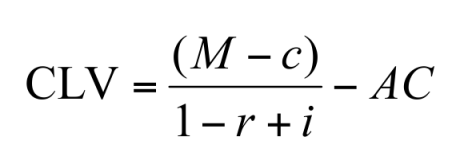

* M: 고객 1인당 평균 매출 (보통 1년단위)
* c: 고객 1인당 평균 비용
* r: 고객 유지 비율(retention rate), 고객이 다음해에도 여전히 남아 있을 확률
* i: 이자율, 할인율 (고려해야 하는 이유: 화폐의 가치는 매년 달라진다.)
* AC: 고객 획득 비용(Acqusition Cost), 고객이 첫 방문,구매 하도록 하는데 드는 비용
* (✔️ 어떤 관점에서 평가하느냐에 따라 CLV를 추정하는 식이 다르고. 추정하는 방법이 다양하다.)

In [ ]:
M = 10000
c = 3000
r = 0.8
i = 0.1
AC= 5000

# CLV = ((M - c) * (1 + r) / (1 + i - r)) - AC
CLV = ((M-c)/(1-r+i)) - AC
CLV

18333.33333333334

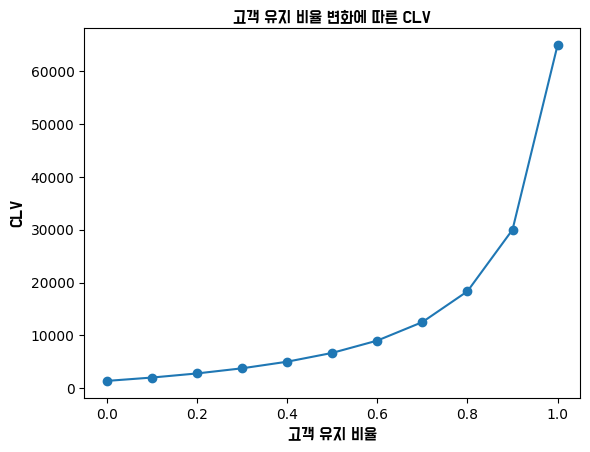

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 주어진 값
M = 10000
c = 3000
i = 0.1
AC= 5000


# 다양한 고객 유지 비율에 대한 계산
r = np.arange(0, 1.1, 0.1)
ltvs = ((M-c)/(1-r+i)) - AC

# 그래프 생성
font_path = "/content/BMDOHYEON_ttf.ttf"
custom_font = fm.FontProperties(fname=font_path)

# 그래프 생성
plt.plot(r, ltvs, marker='o')
plt.xlabel('고객 유지 비율', fontproperties=custom_font)
plt.ylabel('CLV', fontproperties=custom_font)
plt.title('고객 유지 비율 변화에 따른 CLV', fontproperties=custom_font)
plt.show()



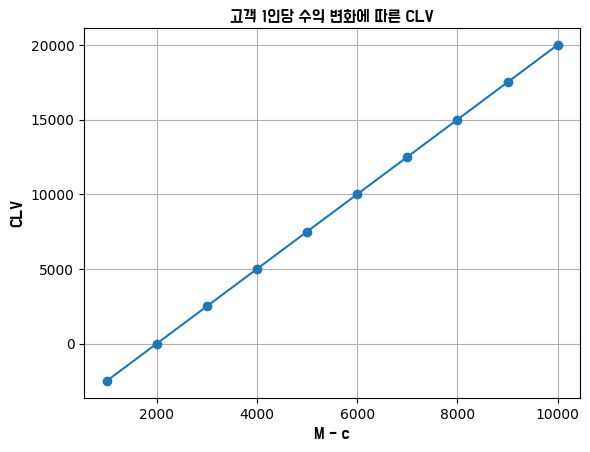

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 주어진 값
c = 3000   # 평균 비용
r = 0.7 # 고객 유지 비율
i = 0.1 # 이자율 또는 할인율
AC = 5000  # 고객 획득 비용

# 다양한 고객 1인당 수익에 대한 계산
revenues_per_customer = np.arange(1000, 10001, 1000)  # 0부터 10000까지 1000 간격의 값
ltvs = ((revenues_per_customer)/(1-r+i)) - AC

# 그래프 생성
plt.plot(revenues_per_customer, ltvs, marker='o')
plt.xlabel('M - c',fontproperties=custom_font)
plt.ylabel('CLV',fontproperties=custom_font)
plt.title('고객 1인당 수익 변화에 따른 CLV',fontproperties=custom_font)
plt.grid(True)
plt.show()


✔️ 당장의 큰매출을 높이기보다, 적절한 비용(AC)을 통한 마케팅을 이용하고, 1인 기여액(M-c) 과 고객을 어떻게 유지할지(r)에 집중하는게 CLV(=LTV) 의 관점이며
그중에서 r이 굉장히 중요하다! 라고 할 수 있다.

# LTV BG/NBD  Gamma Gamma 모델 [예제](https://www.databricks.com/notebooks/clv_part2_estimating_future_spend.html) / [참고](https://playinpap.github.io/ltv-practice/#%EC%B5%9C%EC%A0%81%EC%9D%98-l2-penalty-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-%EC%B0%BE%EA%B8%B0)


이번에는  BG/NBD 와 Gamma Gamma 모델을 이용해서 LTV 값을 산출해보자.

> LTV = 미래의 예상 구매 횟수 * 예상 평균 수익


> BG/NBD 모델은 각 고객의 구매 행동 분포를 모델링하고 각 고객의 예상 거래 수를 예측합니다.

> 감마-감마 하위 모델은 예상 평균 이익 분포를 모델링하고 각 고객의 예상 평균 이익을 예측합니다.


### 위 모델을 통해서 얻을 수 있는것은 무엇인지 요약해보면 다음과 같습니다.

* 다음 기간에는 어떤 고객이 구매를 하게 될 것인지
* 상위 N 고객은 다음 기간에 가장 많은 구매를 할 것으로 예상되는지



# 데이터 불러오기
 kaggle api로 받아오자
 이번에 실습할 데이터는 아래와 같습니다.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"omgcs7750","key":"869481b659ffb4a79e258ade1e024283"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nathaniel/uci-online-retail-ii-data-set

 76% 33.0M/43.3M [00:00<00:00, 69.8MB/s]
100% 43.3M/43.3M [00:00<00:00, 84.5MB/s]


In [ ]:
root = '/content/uci-online-retail-ii-data-set.zip'

!unzip -o {root} -d /content


Archive:  /content/uci-online-retail-ii-data-set.zip
  inflating: /content/online_retail_II.xlsx  


In [ ]:
df = pd.read_excel('/content/online_retail_II.xlsx')
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


## datainfo
* Invoice: Invoice number. If this number starts with ‘C’, it means this transaction is cancelled.
(송장 번호 이며, C 인경우 취소를 의미한다)

* StockCode: Product code (상품 코드)
* Description: Product Name (상품 이름)
* Quantity: Product counts (상품 물량)
* InvoiceDate: Transaction date (거래 날짜)
* Price: A single product price (상품 가격)
* CustomerID: Unique customer number (유니크한 고객 번호)
* Country: Customer’s country name (고객 지역)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


##  고객마다 일자별로 얼마치를 구매했는지

* 일자별로 바꾸기위해 datetime -> date 형으로
* 결측값 컷
* 주문 1개 이상한 고객


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df.dropna(inplace=True)

# C 인경우 반품으로 제거
df = df[~df["Invoice"].str.contains("C", na=False)] # na값 채우는 기능이다. na값을 False로
df = df[df["Quantity"] > 0]
df['TotalPrice'] = df['Price'] * df['Quantity']

In [ ]:
col = ['Customer ID','InvoiceDate', 'TotalPrice']
df2 = df[col]

## BG/NBD 모형의 INPUT
* Recency, 얼마나 최근에 구매했는지
* Frequency, 얼마나 자주 구매했는지
* Monetary, 평균 금액 (얼마나 많이 구매했는지)
* T, 고객별 첫구매~ 집계일까지의 시간

In [ ]:
# 제공하는 패키지 안에서 편하게 구할수 있다.
# 함수 summary_data_from_transaction_data


current_date = df['InvoiceDate'].max()

metrics_df = summary_data_from_transaction_data(df
                                          , customer_id_col = 'Customer ID'
                                          , datetime_col = 'InvoiceDate'
                                          , monetary_value_col='TotalPrice'
                                          , observation_period_end=current_date)
metrics_df.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,6.0,196.0,360.0,47.143333
12347.0,1.0,37.0,39.0,711.790000
12348.0,0.0,0.0,73.0,0.000000
12349.0,2.0,182.0,224.0,801.310000
12351.0,0.0,0.0,10.0,0.000000


In [ ]:
# 직접 계산해야 하는 경우
# F와 M을 계산할 때 첫 구매일을 제외하는 이유는
# “반복되는 구매 행위”에 대한 통계를 계산하고 있기 때문이다.

current_date = df['InvoiceDate'].max()

example = df[df['Customer ID'] == 12347 ]
print(len(example['InvoiceDate'].unique())-1) # 얼마나 자주 빈번하게 구매했는지 (총 1번주문 )
print(max(example['InvoiceDate'] - min(example['InvoiceDate']))) # 가장 최근에 구매한날짜 - 가장오래된날짜  recency
print(current_date - min(example['InvoiceDate'])) # 첫 구매로부터 39일 지났음

m = example.groupby('InvoiceDate')['TotalPrice'].sum()
m = np.mean(m[1:])
print(m)


1
37 days 00:00:00
39 days, 0:00:00
711.79


## 최적의 L2 penalty 파라미터 찾기

* 구한 RFMT을 모형에 INPUT으로 넣어주기전, [L2 penalty](https://lifetimes.readthedocs.io/en/latest/Quickstart.html)를 넣어주면 모형을 좀 더 강건하게 만들 수 있다.

* lifetimes 패키지에서는 훈련 데이터를 calibration data / 테스트 데이터를 holdout data라 부른다.

그러기 위해서는 holddout_days를 정해줘야한다. 디폴트값을 넣어주었다.

결과를 보면 훈련데이터에 '_cal' 테스트 데이터에 '_holdout' 가 추가 된것을 볼 수 있다.

In [ ]:
# define a notebook parameter making holdout days configurable (90-days default)
# 어느 시점을 기준으로 훈련/테스트로 나눌지 정해야한다.

holdout_days = 90
calibration_end_date = current_date - timedelta(days = holdout_days)

metrics_cal_df = calibration_and_holdout_data(df
                                          ,customer_id_col = 'Customer ID'
                                          ,datetime_col = 'InvoiceDate'
                                          ,calibration_period_end=calibration_end_date # train 데이터 기간
                                          ,observation_period_end=current_date         # 끝 기간
                                          ,monetary_value_col='TotalPrice')

metrics_cal_df.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
Customer ID,,,,,,,
12346.0,6.0,196.0,270.0,47.143333,0.0,0.000000,90.0
12349.0,1.0,19.0,134.0,200.000000,1.0,25.502182,90.0
12355.0,0.0,0.0,112.0,0.000000,0.0,0.000000,90.0
12358.0,1.0,181.0,276.0,268.100000,1.0,44.394783,90.0
12359.0,4.0,199.0,279.0,312.835000,1.0,17.784839,90.0


### 고객별 RFMT가 들어간 데이터에서 frequency가 1 이상인 데이터만 가져와야한다.

frequency가 0 인경우 , (총구매일수-1) 값이 0 이기 때문이다.

👉 전체 기간 동안 구매 일수가 1일인 고객
👉 반복적인 구매를 한 고객들이 아니다.
👉 BG/NBD 모형의 가정에 어긋난다.


In [ ]:
## frequency가 0인 것은 제외

whole_filtered_df = metrics_df[metrics_df.frequency > 0] # 훈련/테스트로 분리가 안된 데이터

filtered_df = metrics_cal_df[metrics_cal_df.frequency_cal > 0] # L2 페널티를 최적하기 위해 분리된 데이터

In [ ]:
# 평가 지표: default는 MSE
def score_model(actuals, predicted, metric='mse'):

    metric = metric.lower()

    # MSE / RMSE
    if metric=='mse' or metric=='rmse':
        val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    elif metric=='rmse':
        val = np.sqrt(val)
    # MAE
    elif metric=='mae':
        val = np.sum(np.abs(actuals-predicted))/actuals.shape[0]
    else:
        val = None

    return val

# BG/NBD 모형 평가, 구매일수(frequency)
def evaluate_bgnbd_model(param):

    data   = inputs
    l2_reg = param

    # 모형 적합
    model = BetaGeoFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])

    # 모형 평가
    frequency_actual = data['frequency_holdout']
    frequency_predicted = model.predict(data['duration_holdout']
                                        , data['frequency_cal']
                                        , data['recency_cal']
                                        , data['T_cal']
                                       )
    mse = score_model(frequency_actual, frequency_predicted, 'mse')

    return {'loss': mse, 'status': STATUS_OK}

# Gamma/Gamma 모델 평가 , 평균구매금액(monetary value)
def evaluate_gg_model(param):

    data   = inputs
    l2_reg = param

    # GammaGamma 모형 적합
    model = GammaGammaFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['monetary_value_cal'])

    # 모형 평가
    monetary_actual = data['monetary_value_holdout']
    monetary_predicted = model.conditional_expected_average_profit(data['frequency_holdout'], data['monetary_value_holdout'])
    mse = score_model(monetary_actual, monetary_predicted, 'mse')

    # return score and status
    return {'loss': mse, 'status': STATUS_OK}


In [ ]:

search_space = hp.uniform('l2', 0.0, 1.0)
algo = tpe.suggest
trials = Trials()
inputs = filtered_df

argmin = fmin(
  fn = evaluate_bgnbd_model, # 목적함수
  space = search_space,      # 파라미터 공간
  algo = algo,               # 최적화 알고리즘: Tree of Parzen Estimators (TPE)
  max_evals=100,             # 반복수
  trials=trials
  )

l2_bgnbd = space_eval(search_space,argmin)
print(l2_bgnbd)

# BG/NBD의 penalizer_coef = 0.9996862043879972

100%|██████████| 100/100 [00:13<00:00,  7.39trial/s, best loss: 3.279926477960428]
0.9996862043879972


In [ ]:
trials = Trials()

# GammaGamma
argmin = fmin(
  fn = evaluate_gg_model,
  space = search_space,
  algo = algo,
  max_evals=100,
  trials=trials
  )

l2_gg = space_eval(search_space,argmin)
print(l2_gg)

# gamma gamma의 penalizer_coef = 0.006469987501113946


100%|██████████| 100/100 [00:06<00:00, 15.98trial/s, best loss: 1082.1110116008713]
0.006469987501113946


## 본격적으로 모형 적합하기
BG/NBD 모형은 고객별 미래의 구매 횟수 예측


In [ ]:
lifetimes_model = BetaGeoFitter(penalizer_coef=l2_bgnbd) #l2_bgnbd = hyperopt로 나온 결과

# calibration 데이터의 R,F,T로 모형 적합
# train = _cal
lifetimes_model.fit(filtered_df['frequency_cal'], filtered_df['recency_cal'], filtered_df['T_cal'])

# holdout 데이터로 모델 평가: F의 실제값과 예측값의 MSE
# test = _holdout
frequency_actual = filtered_df['frequency_holdout']
frequency_predicted = lifetimes_model.predict(filtered_df['duration_holdout']
                                    ,filtered_df['frequency_cal']
                                    , filtered_df['recency_cal']
                                    , filtered_df['T_cal'])
mse = score_model(frequency_actual, frequency_predicted, 'mse')
print('MSE: {0}'.format(mse))

# 구매일수에 대한 평균제곱오차 +- 3.2 일

MSE: 3.279926477960428


In [ ]:
# 모델 파라미터
lifetimes_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.452447,0.009554,0.433722,0.471173
alpha,23.179127,0.973003,21.272042,25.086213
a,0.001436,0.000920,-0.000366,0.003239
b,0.023135,0.013261,-0.002856,0.049126


In [ ]:
coefs['a']

0.001435916193621895

## BG/NBD 모형의 가정에 나오는 모수들
r, alpha, a, b 위 모수들을 해석할 수 있다.

- 고객마다 일정한 기간 동안 구매하는 횟수는 다르다. 이는λ ~ Gamma (r,α)을 따른다.

- 고객마다 더 이상 구매를 하지 않을 확률(이탈률)은 다르다. 이탈률은 p- p~Beta(a,b)를 따른다.

- 고객별 일정 기간 동안의 구매 횟수와 구매를 하지 않을 확률은 서로 영향을 주지 않는다.

1,2 번에 해당 => Gamma(r,α) 와 Beta(a,b)

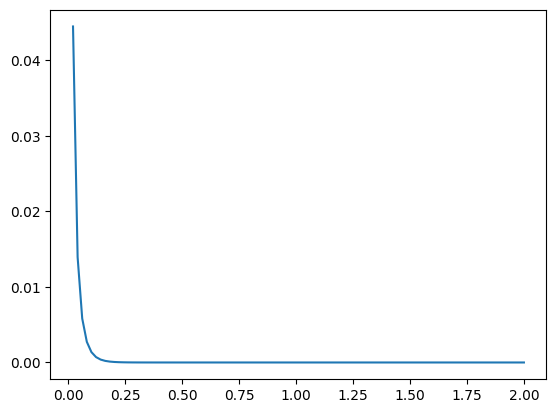

In [ ]:
from scipy.stats import gamma
import matplotlib.pyplot as plt

coefs = lifetimes_model.summary['coef']
x = np.linspace (0, 2, 100)
y = gamma.pdf(x, a=coefs['a'], scale=1/coefs['alpha']) # BG/NBD에서의 모수 alpha는 scale 모수가 아닌 rate 모수이므로 역수!

plt.plot(x, y)

## gamma gamaa 모형 적용

In [ ]:
spend_model = GammaGammaFitter(penalizer_coef=l2_gg)
spend_model.fit(filtered_df['frequency_cal'], filtered_df['monetary_value_cal'])

# conditional_expected_average_profit: 고객별 평균 구매 금액 예측
monetary_actual = filtered_df['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(filtered_df['frequency_holdout']
                                                                    ,filtered_df['monetary_value_holdout'])

mse = score_model(monetary_actual, monetary_predicted, 'mse')

print('MSE: {0}'.format(mse))

MSE: 1082.1110116008713


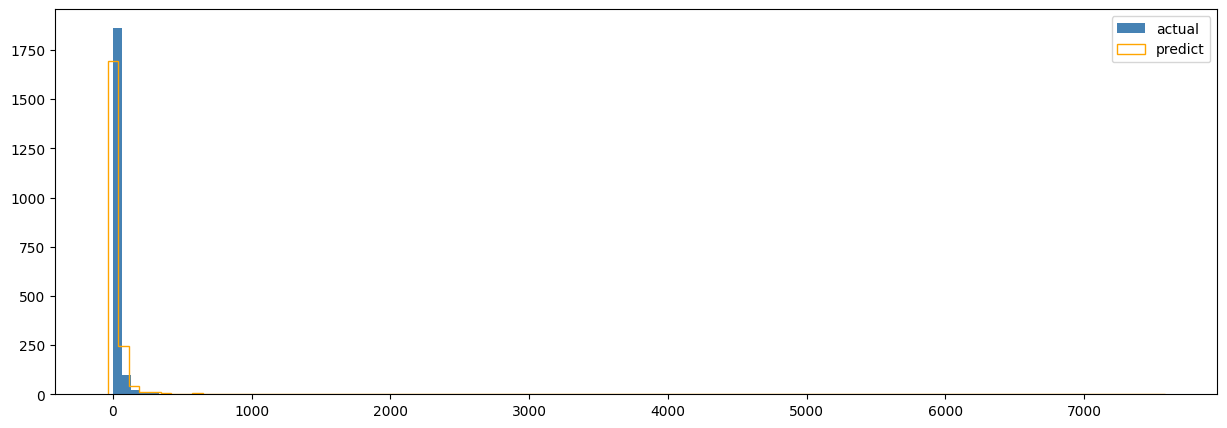

In [ ]:
bins = 100
plt.figure(figsize=(15, 5))

plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist(monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)
plt.legend(loc='upper right')

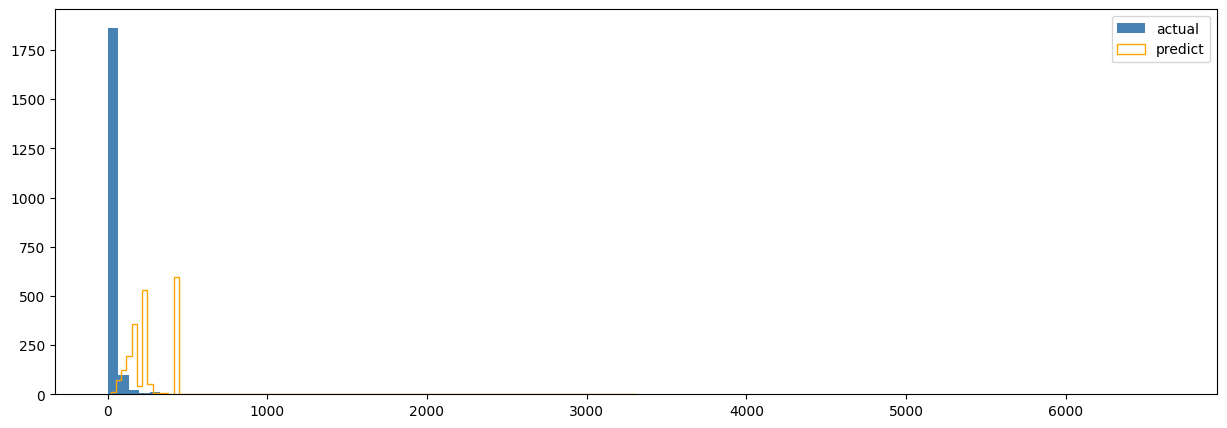

In [ ]:
# penalizer_coef 없이 했을 때의 결과
spend_model = GammaGammaFitter(penalizer_coef=0)
spend_model.fit(filtered_df['frequency_cal'], filtered_df['monetary_value_cal'])

# 평가
monetary_actual = filtered_df['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(filtered_df['frequency_holdout']
                                                                    ,filtered_df['monetary_value_holdout'])

mse = score_model(monetary_actual, monetary_predicted, 'mse')

bins = 100
plt.figure(figsize=(15, 5))

plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist( monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)
plt.legend(loc='upper right')

# LTV 구하기

In [ ]:
final_df = whole_filtered_df.copy() # 전체 데이터 대상
final_df['ltv'] = spend_model.customer_lifetime_value(lifetimes_model,
                                                     final_df['frequency'],
                                                     final_df['recency'],
                                                     final_df['T'],
                                                     final_df['monetary_value'],
                                                     time=12,
                                                     discount_rate=0.01 # monthly discount rate ~12.7% 연간
                                                     )

In [ ]:
# NBD 모형 -   예상 구매 횟수
# 기간은 정할 수 있다 t = 365
final_df['predicted_purchases'] = lifetimes_model.conditional_expected_number_of_purchases_up_to_time(t
                                                                                      , final_df['frequency']
                                                                                     , final_df['recency']
                                                                                     , final_df['T'])

In [ ]:
# gamma gamma 모형-  output "예상 평균 구매 금액"
final_df['predicted_monetary_value'] = spend_model.conditional_expected_average_profit(final_df['frequency']
                                                                    ,final_df['monetary_value'])



In [ ]:
final_df.sort_values(by="ltv", ascending=False).head(5)

,frequency,recency,T,monetary_value,ltv,predicted_purchases,predicted_monetary_value
Customer ID,,,,,,,
18102.0,42.0,373.0,373.0,8259.002619,291137.493713,39.089220,8051.145648
14646.0,45.0,363.0,372.0,5393.010222,204527.701978,41.955018,5269.686420
14156.0,78.0,367.0,373.0,2506.409487,165471.495699,72.235718,2476.211914
14911.0,127.0,373.0,373.0,1192.235748,128686.433543,117.359114,1185.311744
13694.0,48.0,362.0,370.0,2685.693750,109487.873163,44.952078,2632.890363


# 해석

* 가장 높은 ltv 값을 갖는 고객 : 18102.0 고객
* 평균 구매 금액이 '8259' 로 가장 높다. 약, 13,780,719 원
* 373일 동안 42번 구매했다. 약, 9일에 한번꼴로 구매하는 고객
* T-recency 값이 0 , 오늘도 구매했다.

> LTV 모형을 통해서 내년에 4.8억 정도의 금액을 쓸 거라고 예상했다.

이는 bg/nbd 모형으로 예측된 구매회수 39 와, gamma gamma 모형으로 예측된 13,800,000 원을 곱하고 할인율을 적용시킨 예측값이다!

> 만약 모형을 쓰지 않고, 단순히 계산한다면. 42 * 13,800,000 원  = 5.8억 정도 구매할거라고 예상하게 된다.





## 함수명 정리




|함수명|	용도|
|:---:|:---:|
|summary_data_from_transaction_data	|구매기록 데이터에서 고객별 RFMT 계산
|calibration_and_holdout_data	훈련| / 테스트를 나눠 고객별 RFMT 계산
|fmin|	L2 penalty 최적화
|BetaGeoFitter|	예상 구매 일수를 구하기 위한 BG/NBD 모형 적함
|conditional_expected_number_of_purchases_up_to_time	|t 시점까지의 예상 구매 일수 계산
|GammaGammaFitter|	예상 평균 구매 금액을 구하기 위한 Gamma-Gamma 모형 적합
|conditional_expected_average_profit|	예상 평균 구매 금액 계산
|customer_lifetime_value|	고객별 LTV 계산

[자료](https://playinpap.github.io/ltv-practice/#%EC%B5%9C%EC%A0%81%EC%9D%98-l2-penalty-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-%EC%B0%BE%EA%B8%B0)